Data **`sentiment`** 3000 kalimat (sentences) reviews dari `imdb.com`, `amazon.com`, and `yelp.com`. Dimana tiap kalimat diberi label berdasarkan reviews tersebut tergolong positive review atau negative review.

Kita akan menggunakan <font color="magenta">logistic regression</font> untuk menerapkan classifier dari data tersebut.

Data source: `full_set.txt` https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled
Sources: edx.org UCSanDiegoX DSE220x Machine Learning Fundamentals asset week 4.

## 1. Set up notebook, load and preprocess data

Import library yang diperlukan.

In [134]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

Load data `full_set.txt` pada folder `sentiment_labelled_sentences`.

 Data set terdapat 3000 kalimat yang diberi label '1' (positive review) atau '0' (negative review). Disini kita akan mengganti label '0' untuk negative review menjadi '-1'.

In [135]:
with open("sentiment_labelled_sentences/full_set.txt") as f:
    content = f.readlines()

content = [x.strip() for x in content] #Menghilangkan new space('\n') pada tiap kalimat
# Split kalimat dan labels
sentences = [x.split('\t')[0] for x in content]
labels = [x.split('\t')[1] for x in content]

# Membentuk array dari labels dengan element 1 dan -1
y = np.array(labels, dtype='int64')
y = 2*y-1

### Preprocessing the text data

Untuk dapat menerapkan linear classification pada permasalahan ini, pertama kita akan melakukan preprocess text data. Kita akan menerapkan empat transformation antara lain:

1. Remove punctuation and numbers.
2. Transform all words to lower-case.
3. Remove _stop words_.
4. Convert the sentences into vectors, using a bag-of-words representation.

Dua langkah pertama dapat diterapkan sebagai berikut.

In [136]:
## full_remove mengambil sebuah string x and sebuah list characters removal_list 
## returns x dengan semua karakter di removal_list yang diganti dengan ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x.replace(w, ' ')
    return x
# Remove digits dari sentences
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x,digits) for x in sentences]

# Remove punctuations dari kalimat-kalimat di list digit_less
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

# Membuat semua kalimat di list punc_less menjadi huruf kecil 
sent_lower = [x.lower() for x in punc_less]

### Stop words

Stop words adalah kumpulan kata-kata yang akan kita hilangkan dari data, dikarenakan kata-kata tersebut dianggap tidak memberikan informasi dalam membedakan kalimat yang berupa positive dan negative review. Contohnya 'a', 'the', 'i', 'they', 'to' dan 'from'. Silahkan menggunakan kata-kata sebagai stop words yang berbeda.

In [137]:
## Definisikan kata-kata yang termasuk stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

sents_split = [x.split() for x in sent_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

# list sents_processed juga bisa dilakukan dengan for looping berikut
#sents_processed2 = []
#for i in sent_split:
    #cc.append(' '.join([x for x in i if x not in stop_set]))
#sents_processed2

### Bag of words

Untuk dapat menerapkan linear classifiers pada data set yang kita miliki, kita perlu mentransform data text menjadi suatu data numerik. Cara yang biasa digunakan adalah sebagai _bag of words_ representation. 

Dalam representasi ini, tiap kata berkorespondensi pada bilangan di `{1, 2, ..., V}` dimana `V` adalah jumlah banyaknya kata-kata berbeda dalam data set. Dan tiap kalimat pada data set direpresentasikan sebagai suatu V-dimensional vector $x$, dimana $x_i$ frekuensi kemunculan kata $i$ dalam kalimat.

Untuk dapat melakukan transformation ini, kita akan gunakan `CountVectorizer` class pada `scikit-learn`. Kita akan jadikan jumlah fitur sebanyak 4500, yang artinya kita akan mencari 4500 frekuensi kata terbesar pada data set.

#Finally, we will also append a '1' to the end of each vector to allow our linear classifier to learn a bias term.

In [138]:
from sklearn.feature_extraction.text import CountVectorizer

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)

## Append '1' to the end of each vector.
data_mat = data_features.toarray()

p_mat = data_features.toarray() #Membuat data_mat menjadi array
data_mat = np.ones((p_mat.shape[0], p_mat.shape[1]+1)) #Membuat matrix dengan 1 kolom tambahan untuk 'y'
data_mat[:,:-1] = p_mat

In [139]:
## Split the data into testing and training sets
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,:-1]
train_labels = y[train_inds]

test_data = data_mat[test_inds,:-1]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)

train data:  (2500, 4500)
test data:  (500, 4500)


## 2. Fitting a logistic regression model to the training data

Kita dapat mencari koefisien $(w_1,w_2,...w_{4500})$ dan intercept $b$ linear function pada logistic regression dengan menggunakan konsep *stochastic gradient descent*, untungnya hal tersebut sudah terdapat dalam `scikit-learn`.

#Due to the randomness in the SGD procedure, different runs can yield slightly different solutions (and thus different error values).

In [140]:
from sklearn.linear_model import SGDClassifier

## Fit logistic classifier on training data
clf = SGDClassifier(loss="log", penalty="none")
clf.fit(train_data, train_labels)

## Pull out the parameters (w,b) of the logistic regression model
w = clf.coef_[0,:]
b = clf.intercept_

## Get predictions on training and test data
preds_train = clf.predict(train_data)
preds_test = clf.predict(test_data)

## Compute errors
errs_train = np.sum(preds_train != train_labels)
errs_test = np.sum(preds_test != test_labels)

print("Training error: ", float(errs_train)/len(train_labels))
print("Test error: ", float(errs_test)/len(test_labels))

Training error:  0.0008
Test error:  0.188


## 3. Analyzing the margin

Logistic regression model tidak hanya menghasikan suatu prediksi tapi juga memberikan peluang atas prediksi tersebut. Misalkan pada baris data set pertama diprediksikan sebagai label "-1"  dengan peluang 0.73.

Misal `x` mempunyai **margin** `gamma` jika (berdasarkan logistic regression model) `Pr(y=1|x) > (1/2)+gamma` atau `Pr(y=1|x) < (1/2)-gamma`. Functio **margin_counts** berikut memproses input classifier (`clf`, yang sudah didefinisikan sebelumnya), test set (`test_data`), dan `gamma`, dan mencari banyaknya points pada data set yang memiliki margin minimal `gamma`.

Sebagai contoh:
- Misal baris ke-2 diberi label "1" dengan probability 0.6
- Misal baris ke-7 diberi label "1" dengan probability 0.8

Apabila ditentukan nilai `gamma` sebesar 0.2, maka baris ke-7 akan termasuk output dari **margin_counts**, sedangkan baris ke-2 tidak termasuk.

In [141]:
## Return banyaknya titik data dengan Pr(y=1) dimana [0, 0.5 - gamma) or (0.5 + gamma, 1]
def margin_counts(clf, test_data, gamma):
    ## Mencari kumpulan Pr(y=1) pada test_data
    preds = clf.predict_proba(test_data)[:,1]
    margin_inds = np.sum((preds > (0.5+gamma)) | (preds < (0.5-gamma)))
    
    return margin_inds

Kita akan coba visualisasikan distribusi margin values pada test_data.

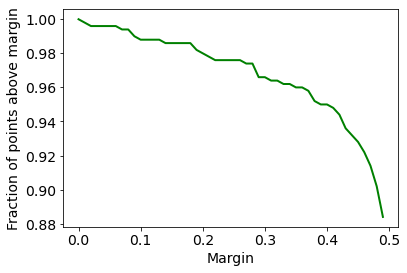

In [142]:
gammas = np.arange(0,0.5,0.01) #Membuat interval gamma
f = np.vectorize(lambda g: margin_counts(clf, test_data, g)) #Membuat function yang menghasilkan vector dengan input vector gammas
plt.plot(gammas, f(gammas)/500.0, linewidth=2, color='green')
plt.xlabel('Margin', fontsize=14)
plt.ylabel('Fraction of points above margin', fontsize=14)
plt.show()

Berikutnya kita akan investigasi: <font color="magenta">Apakah titik data `x` dengan margin lebih besar cenderung terklasifikasi dengan benar?</font>

Untuk menjawabnya, kita akan mendefinisikan suatu function **margin_errors** yang menghasilkan rasio titik data yang memiliki margin minimal `gamma` tidak terklasifikasikan dengan benar atau misclassified.

In [143]:
## Return error of predictions that lie in intervals [0, 0.5 - gamma) and (0.5 + gamma, 1]
def margin_errors(clf, test_data, test_labels, gamma):
    ## Compute probability on each test point
    preds = clf.predict_proba(test_data)[:,1]
    
    ## Find data points for which prediction is at least gamma away from 0.5
    margin_inds = (preds > (0.5+gamma)) | (preds < (0.5-gamma))
    
    ## Compute error on those data points.
    errors_ind = (preds[margin_inds] > 0.5) != (test_labels[margin_inds] > 0.0)
    return np.sum(errors_ind)/np.sum(margin_inds)

Kita akan coba visualisasikan margin dan error_rate

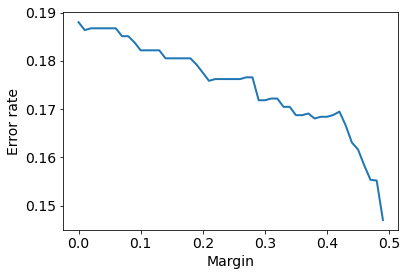

In [144]:
## Create grid of gamma values
gammas = np.arange(0, 0.5, 0.01)

## Compute margin_errors on test data for each value of g
f = np.vectorize(lambda g: margin_errors(clf, test_data, test_labels, g))

## Plot the result
plt.plot(gammas, f(gammas), linewidth=2)
plt.ylabel('Error rate', fontsize=14)
plt.xlabel('Margin', fontsize=14)
plt.show()

Dapat kita lihat, margin yang lebih besar cenderung memiliki error rate yang lebih kecil.